# Voice Recognition

## EDA & Data Preparation

### Library

In [1]:
#Library
import pandas as pd
from datasets import load_dataset, Audio, DatasetDict, concatenate_datasets
import seaborn as sns
import matplotlib.pyplot as plt
import os
import librosa
from IPython.display import Audio
#!pip install librosa soundfile (if not installed)

c:\Users\shining\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Splitting Datasets to 80% / 20%

In [2]:
minds_us = load_dataset('csv', data_files='F:\AI Portfolio Project\Project-3\datasets\MInDS-14\\text\en-US.csv')

In [3]:
# Splitting the dataset into 80% for Training and Test/Val 20%
minds_train = minds_us['train'].train_test_split(test_size=0.2)
# Split the 10% test + valid in half test, half valid
minds_test_val = minds_train['test'].train_test_split(test_size=0.5)
# Create a DatasetDict with the new splits
minds_datasets = DatasetDict({
    'train': minds_train['train'],
    'test': minds_test_val['test'],
    'valid': minds_test_val['train']})

print(minds_datasets)

DatasetDict({
    train: Dataset({
        features: ['filepath', 'text_asr', 'text_translated', 'intent'],
        num_rows: 450
    })
    test: Dataset({
        features: ['filepath', 'text_asr', 'text_translated', 'intent'],
        num_rows: 57
    })
    valid: Dataset({
        features: ['filepath', 'text_asr', 'text_translated', 'intent'],
        num_rows: 56
    })
})


In [4]:
# Converting into dataframe and then save into csv files
minds_traindf = minds_datasets['train'].to_pandas()
minds_testdf = minds_datasets['test'].to_pandas()
minds_valdf = minds_datasets['valid'].to_pandas()

minds_traindf.to_csv('F:\AI Portfolio Project\Project-3\datasets_split\\minds_traindf.csv', index=False)
minds_testdf.to_csv('F:\AI Portfolio Project\Project-3\datasets_split\\minds_testdf.csv', index=False)
minds_valdf.to_csv('F:\AI Portfolio Project\Project-3\datasets_split\\minds_valdf.csv', index=False)

### Testing 1 / Exploring one of the datasets TEXT

In [2]:
#Testing 1 / Exploring one of the datasets TEXT
minds14_us = pd.read_csv('F:\AI Portfolio Project\Project-3\datasets_split\\minds_traindf.csv')
minds14_us

,filepath,text_asr,text_translated,intent
0,en-US~FREEZE/602baeca5f67b421554f64c1.wav,I want to stop all transactions this card,I want to stop all transactions this card,FREEZE
1,en-US~FREEZE/602ba34c05f96973d679441b.wav,hello my wallet is stolen and I'd like to put ...,hello my wallet is stolen and I'd like to put ...,FREEZE
2,en-US~ABROAD/602b9696963e11ccd901cb79.wav,I need my card abroad can I pay for things I'm...,I need my card abroad can I pay for things I'm...,ABROAD
3,en-US~LATEST_TRANSACTIONS/602b9f12963e11ccd901...,how do I see my most recent transactions,how do I see my most recent transactions,LATEST_TRANSACTIONS
4,en-US~APP_ERROR/602b97d1bb1e6d0fbce91f1f.wav,hello I'm calling for technical difficulties I...,hello I'm calling for technical difficulties I...,APP_ERROR
...,...,...,...,...
445,en-US~LATEST_TRANSACTIONS/602ba4a0bb1e6d0fbce9...,Ohio can you show me all of my latest transact...,Ohio can you show me all of my latest transact...,LATEST_TRANSACTIONS
446,en-US~BALANCE/602badf5bb1e6d0fbce92224.wav,what's my account balance,what's my account balance,BALANCE
447,en-US~FREEZE/602b9e95bb1e6d0fbce91fbb.wav,hi I lost my card I'd like to freeze my card s...,hi I lost my card I'd like to freeze my card s...,FREEZE
448,en-US~CARD_ISSUES/602ba965bb1e6d0fbce92124.wav,hello I'm going to cuz I have a problem with m...,hello I'm going to cuz I have a problem with m...,CARD_ISSUES


In [3]:
#checking "intent" section
minds14_us['intent'].unique()

array(['FREEZE', 'ABROAD', 'LATEST_TRANSACTIONS', 'APP_ERROR',
       'DIRECT_DEBIT', 'BUSINESS_LOAN', 'HIGH_VALUE_PAYMENT', 'ADDRESS',
       'BALANCE', 'CASH_DEPOSIT', 'CARD_ISSUES', 'ATM_LIMIT', 'PAY_BILL',
       'JOINT_ACCOUNT'], dtype=object)

C:\Users\shining\AppData\Local\Temp\ipykernel_2312\4124500306.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='intent', data=minds14_us, order=minds14_us['intent'].value_counts().index, palette='flare')


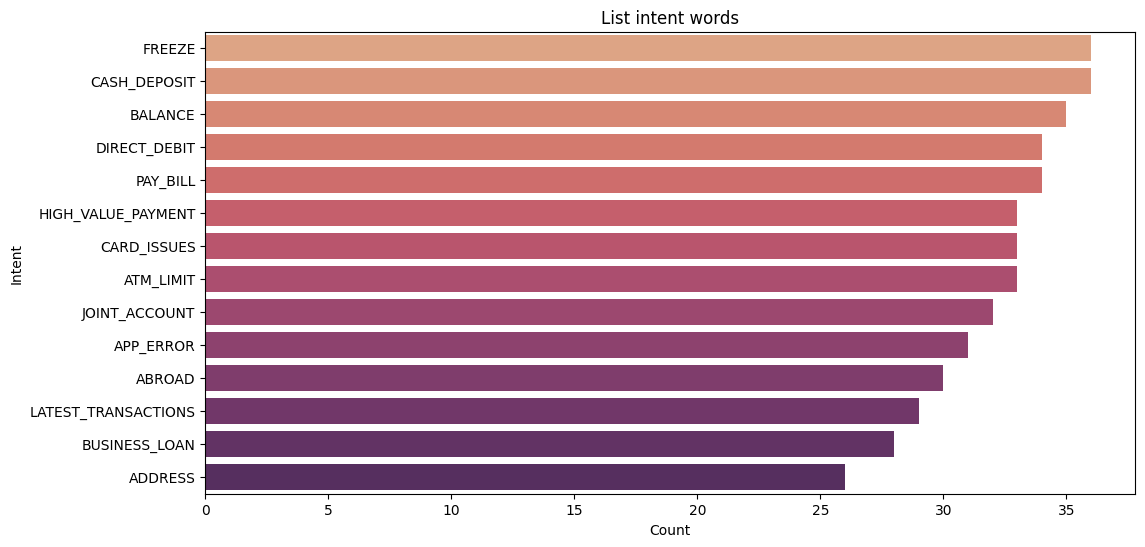

In [ ]:
#Checking "intent" distribution words with matplotlib
plt.figure(figsize=(12, 6))
sns.countplot(y='intent', data=minds14_us, order=minds14_us['intent'].value_counts().index, palette='flare')
plt.xlabel('Count')
plt.ylabel('Intent_Train')
plt.title('List intent words')
plt.show()

### Testing 2 / Exploring one of the datasets AUDIO

In [5]:
#Testing 2 / Exploring one of the datasets AUDIO

#This 2 Lines for defining the audio and csv file/path
def load_audio_data(csv_file, audio_base_path):
    """
    Load audio data from a CSV file and return a DataFrame with additional audio data.
    """
    df = pd.read_csv(csv_file)
    
    # Add a column for audio data
    df['audio_data'] = df['filepath'].apply(lambda x: load_audio(os.path.join(audio_base_path, x)))
    
    return df

def load_audio(file_path):
    """
    Load an audio file and return the audio data and sample rate.
    """
    data, sr = librosa.load(file_path, sr=None)
    return data, sr

#This 2 Lines for creating waveplot and spectogram
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} intent'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} intent'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()
    plt.show()


def play_audio(data, sr):
    return Audio(data, rate=sr)


I want to stop all transactions this card


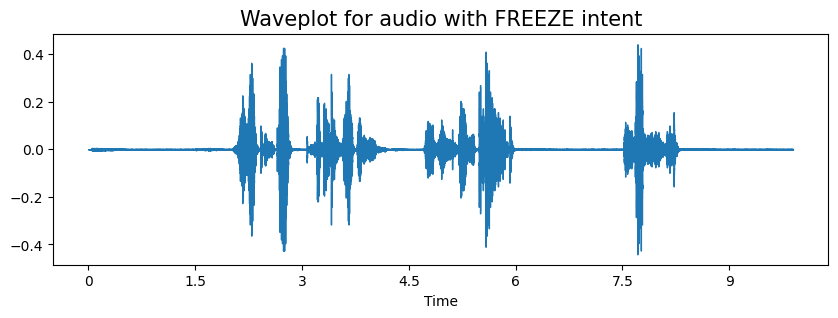

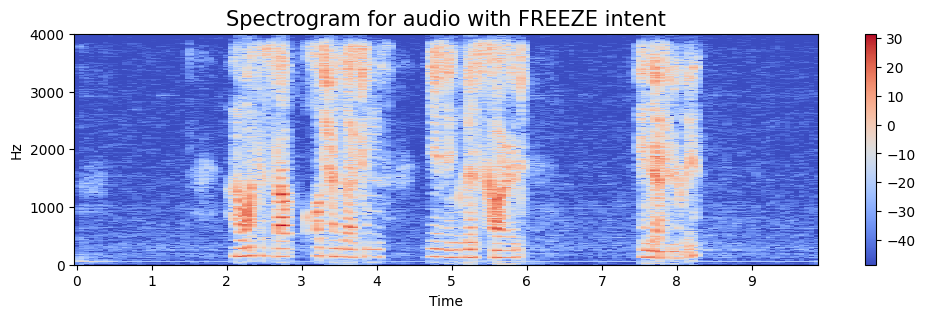

hello my wallet is stolen and I'd like to put a block on my card


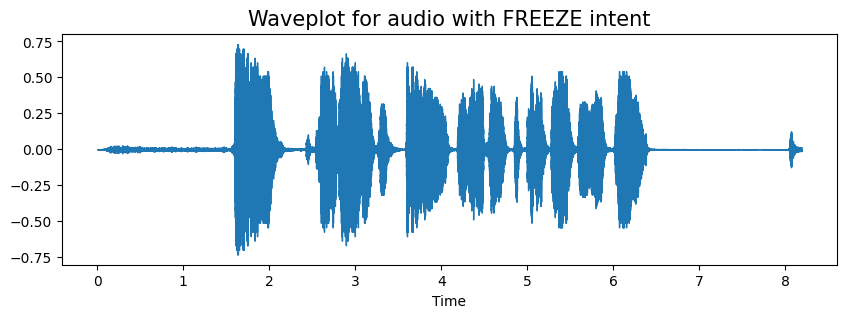

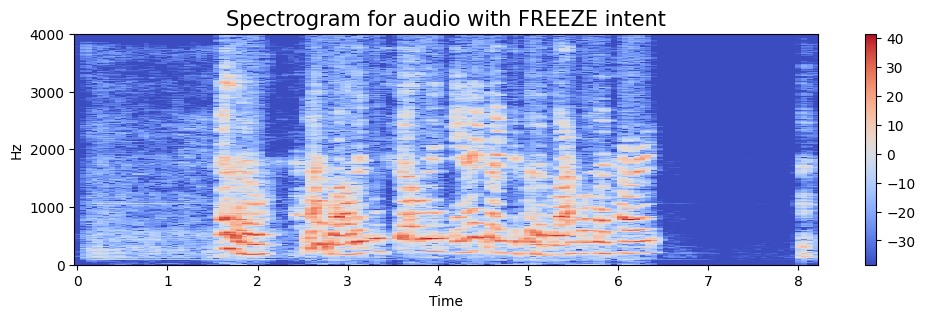

In [6]:
#This section for test waveplot and spectogram

#Load Audio File and CSV File
csv_file = "F:\AI Portfolio Project\Project-3\datasets_split\\minds_traindf.csv"
audio_base_path = "F:\\AI Portfolio Project\\Project-3\\datasets\\MInDS-14\\audio"

df = load_audio_data(csv_file, audio_base_path)

# Make plotting for the first few rows as an example
for index, row in df.head(2).iterrows():
    data, sr = row['audio_data']
    print(row['text_asr'])
    create_waveplot(data, sr, row['intent'])
    create_spectrogram(data, sr, row['intent'])
    display(play_audio(data, sr))

### Testing 3 / Exploring Auxilary data

In [7]:
#Testing 3 / Exploring Auxilary data
minds14_aux = pd.read_csv('F:\AI Portfolio Project\Project-3\datasets\MInDS-14\\aux-en.csv')
minds14_aux
#checking auxilary data file

,I need to pay a bill,PAY_BILL
0,pay bills,PAY_BILL
1,make a payment,PAY_BILL
2,can i pay a bill please,PAY_BILL
3,can i pay a bill,PAY_BILL
4,i want to pay a bill please,PAY_BILL
...,...,...
654,I've got some cash to deposit,CASH_DEPOSIT
655,How do I transfer cash into the account,CASH_DEPOSIT
656,Can I come to a branch to give you some cash t...,CASH_DEPOSIT
657,Where do I go to deposit cash?,CASH_DEPOSIT


In [8]:
#Make a columns for 'text' and 'intent'. because there is no columns for text and intent word
minds14_aux.columns = ['text', 'intent']
#checking aux file head and tail
minds14_aux.head()

,text,intent
0,pay bills,PAY_BILL
1,make a payment,PAY_BILL
2,can i pay a bill please,PAY_BILL
3,can i pay a bill,PAY_BILL
4,i want to pay a bill please,PAY_BILL


In [9]:
minds14_aux.tail()

,text,intent
654,I've got some cash to deposit,CASH_DEPOSIT
655,How do I transfer cash into the account,CASH_DEPOSIT
656,Can I come to a branch to give you some cash t...,CASH_DEPOSIT
657,Where do I go to deposit cash?,CASH_DEPOSIT
658,Can I deposit cash at an ATM?,CASH_DEPOSIT


C:\Users\shining\AppData\Local\Temp\ipykernel_2312\3077251380.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='intent', data=minds14_aux, order=minds14_aux['intent'].value_counts().index, palette='flare')


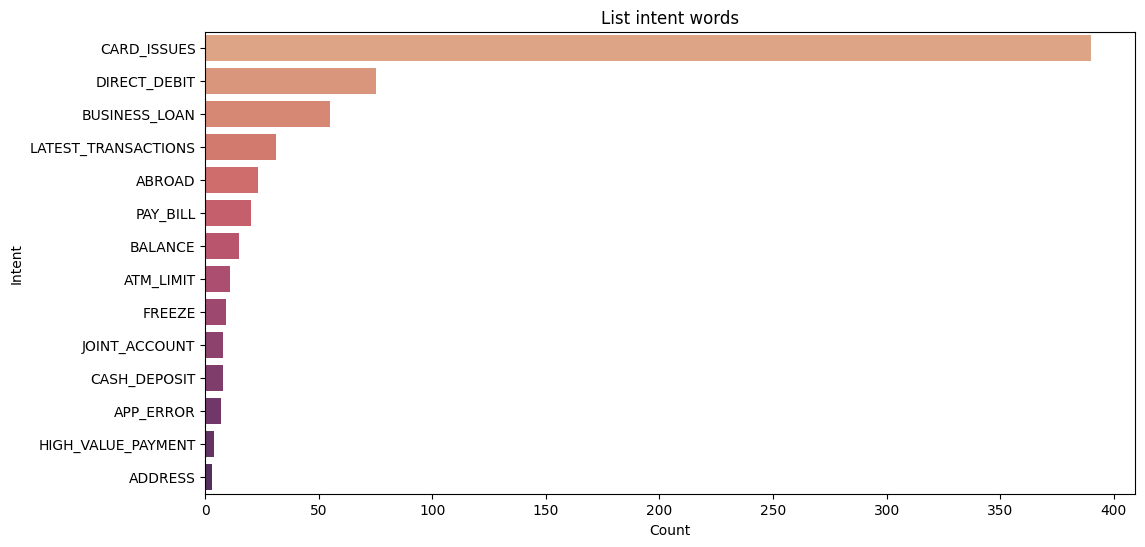

In [ ]:
#Checking "intent" distribution words with matplotlib at auxilary data after add columns
plt.figure(figsize=(12, 6))
sns.countplot(y='intent', data=minds14_aux, order=minds14_aux['intent'].value_counts().index, palette='flare')
plt.xlabel('Count')
plt.ylabel('Intent_Auxilary')
plt.title('List intent words')
plt.show()